# Gender Classification from Urdu Audio

## 1. Import all the necessary Libraries

In [35]:
import os
import pandas as pd
import librosa
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.svm import SVC
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import ModelCheckpoint
import joblib

## 2. Dataset Structure and Label Parsing

### 2.1 Set Dataset path

In [4]:
DATASET_PATH = "/kaggle/input/urdu-speech-dataset/files"

### 2.2 Label Parsing


In [5]:
data = []

for speaker_folder in os.listdir(DATASET_PATH):
    speaker_path = os.path.join(DATASET_PATH, speaker_folder)

    if not os.path.isdir(speaker_path):
        continue
 
    speaker_id = speaker_folder[:2]
    gender = speaker_folder[2]          
    native_status = speaker_folder[3]   
    age_group = speaker_folder[4:]      

    for wav_file in os.listdir(speaker_path):
        if wav_file.endswith(".wav"):
            word_id = wav_file[-7:-4]   

            data.append({
                "speaker_id": speaker_id,
                "gender": gender,
                "native": native_status,
                "age_group": age_group,
                "word_id": word_id,
                "file_path": os.path.join(speaker_path, wav_file)
            })
 
df = pd.DataFrame(data)

print(df.head())
print(df["gender"].value_counts())

  speaker_id gender native age_group word_id  \
0         AJ      M      N        G2     012   
1         AJ      M      N        G2     026   
2         AJ      M      N        G2     022   
3         AJ      M      N        G2     091   
4         AJ      M      N        G2     148   

                                           file_path  
0  /kaggle/input/urdu-speech-dataset/files/AJMNG2...  
1  /kaggle/input/urdu-speech-dataset/files/AJMNG2...  
2  /kaggle/input/urdu-speech-dataset/files/AJMNG2...  
3  /kaggle/input/urdu-speech-dataset/files/AJMNG2...  
4  /kaggle/input/urdu-speech-dataset/files/AJMNG2...  
gender
M    2000
F     500
Name: count, dtype: int64


## 3. Data Integrity Checks

### 3.1 Check Data Integrity

In [9]:
sample_rates = []
durations = []
corrupted_files = []

for idx, row in tqdm(df.iterrows(), total=len(df)):
    file_path = row["file_path"]

    try:
        audio, sr = librosa.load(file_path, sr=None)  
        sample_rates.append(sr)
        durations.append(len(audio) / sr)

    except Exception as e:
        corrupted_files.append(file_path)

sample_rates = np.array(sample_rates)
durations = np.array(durations)

print("Unique sample rates:", np.unique(sample_rates))
print("Total corrupted files:", len(corrupted_files))
print("Duration stats (seconds):")
print("Min:", durations.min())
print("Max:", durations.max())
print("Mean:", durations.mean())

100%|██████████| 2500/2500 [00:34<00:00, 72.39it/s] 

Unique sample rates: [16000]
Total corrupted files: 0
Duration stats (seconds):
Min: 0.39975
Max: 0.901
Mean: 0.5489795


### 3.2 Duration Visualization

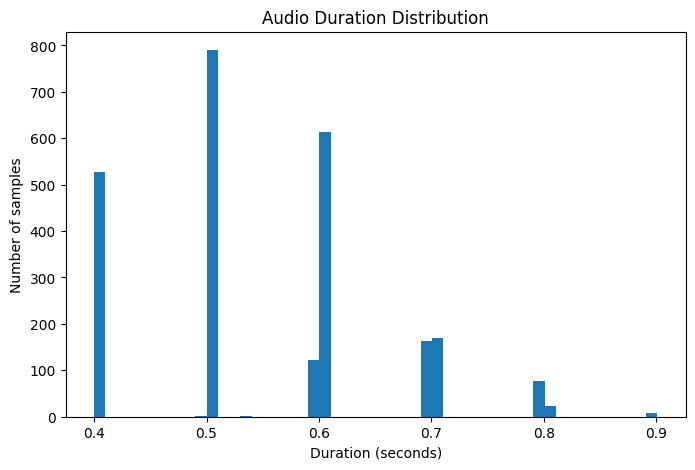

In [11]:
PLOTS_DIR = "plots"
os.makedirs(PLOTS_DIR, exist_ok=True)

plt.figure(figsize=(8, 5))
plt.hist(durations, bins=50)
plt.xlabel("Duration (seconds)")
plt.ylabel("Number of samples")
plt.title("Audio Duration Distribution")

plot_path = os.path.join(PLOTS_DIR, "audio_duration_distribution.png")
plt.savefig(plot_path)
plt.show()
plt.close()

## 4. Speaker-wise Train/Test Split

### 4.1 Extracting Unique Speakers and their Genders

In [12]:
speaker_gender = (
    df[["speaker_id", "gender"]]
    .drop_duplicates()
    .reset_index(drop=True)
)

print("Speakers and genders:")
print(speaker_gender)

Speakers and genders:
  speaker_id gender
0         AJ      M
1         AH      M
2         AA      M
3         AI      M
4         AE      F
5         AK      M
6         AF      F
7         AG      M
8         AB      M
9         AC      M


### 4.2 Split Speakers

In [13]:
train_speakers, test_speakers = train_test_split(
    speaker_gender,
    test_size=0.3,           
    stratify=speaker_gender["gender"],
    random_state=42
)

print("Train speakers:")
print(train_speakers)

print("\nTest speakers:")
print(test_speakers)

Train speakers:
  speaker_id gender
0         AJ      M
9         AC      M
6         AF      F
7         AG      M
8         AB      M
2         AA      M
1         AH      M

Test speakers:
  speaker_id gender
4         AE      F
5         AK      M
3         AI      M


### 4.3 Create Train/Test DataFrames

In [14]:
train_df = df[df["speaker_id"].isin(train_speakers["speaker_id"])]
test_df  = df[df["speaker_id"].isin(test_speakers["speaker_id"])]

print("Train size:", len(train_df))
print("Test size:", len(test_df))

print("\nTrain gender distribution:")
print(train_df["gender"].value_counts())

print("\nTest gender distribution:")
print(test_df["gender"].value_counts())

Train size: 1750
Test size: 750

Train gender distribution:
gender
M    1500
F     250
Name: count, dtype: int64

Test gender distribution:
gender
M    500
F    250
Name: count, dtype: int64


## 5. Feature Extraction (MFCCs)

In [16]:
N_MFCC = 13

def extract_mfcc(file_path, n_mfcc=N_MFCC):
    audio, sr = librosa.load(file_path, sr=16000)  
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)

    mfcc_mean = np.mean(mfcc, axis=1)
    return mfcc_mean

X_train = []
y_train = []

for idx, row in tqdm(train_df.iterrows(), total=len(train_df)):
    mfcc_feat = extract_mfcc(row["file_path"])
    X_train.append(mfcc_feat)
    y_train.append(0 if row["gender"] == "M" else 1)  

X_train = np.array(X_train)
y_train = np.array(y_train)

X_test = []
y_test = []

for idx, row in tqdm(test_df.iterrows(), total=len(test_df)):
    mfcc_feat = extract_mfcc(row["file_path"])
    X_test.append(mfcc_feat)
    y_test.append(0 if row["gender"] == "M" else 1)

X_test = np.array(X_test)
y_test = np.array(y_test)

print("Train features shape:", X_train.shape)
print("Test features shape:", X_test.shape)

100%|██████████| 750/750 [00:09<00:00, 80.32it/s]

Train features shape: (1750, 13)
Test features shape: (750, 13)


## 6. Train Logistic Regression

### 6.1 Training and Evaluation

In [22]:
model = LogisticRegression(class_weight='balanced', random_state=42, max_iter=500)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=['Male','Female']))

Accuracy: 0.8466666666666667

Classification Report:
               precision    recall  f1-score   support

        Male       0.82      0.99      0.90       500
      Female       0.97      0.56      0.71       250

    accuracy                           0.85       750
   macro avg       0.89      0.77      0.80       750
weighted avg       0.87      0.85      0.83       750



### 6.2 Confusion Matrix

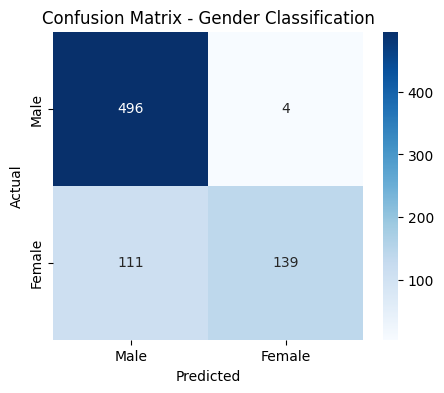

In [23]:
cm = confusion_matrix(y_test, y_pred)
labels = ['Male', 'Female']

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Gender Classification")

cm_plot_path = os.path.join(PLOTS_DIR, "confusion_matrix.png")
plt.savefig(cm_plot_path)
plt.show()
plt.close()

### 6.3 Save Logistic Regression Model

In [36]:
MODELS_DIR = "saved_models"
os.makedirs(MODELS_DIR, exist_ok=True)

logreg_path = os.path.join(MODELS_DIR, "logistic_regression_model.pkl")
joblib.dump(model, logreg_path)
print(f"Logistic Regression model saved at: {logreg_path}")

Logistic Regression model saved at: saved_models/logistic_regression_model.pkl


## 7. Training a SVM 

### 7.1 Training and Evaluation

In [27]:
svm_model = SVC(kernel='rbf', class_weight='balanced', random_state=42)

svm_model.fit(X_train, y_train)

y_pred_svm = svm_model.predict(X_test)

acc = accuracy_score(y_test, y_pred_svm)
report = classification_report(y_test, y_pred_svm, target_names=['Male','Female'])

print("SVM Accuracy:", acc)
print("\nSVM Classification Report:\n", report)

SVM Accuracy: 0.9013333333333333

SVM Classification Report:
               precision    recall  f1-score   support

        Male       0.87      1.00      0.93       500
      Female       1.00      0.70      0.83       250

    accuracy                           0.90       750
   macro avg       0.94      0.85      0.88       750
weighted avg       0.91      0.90      0.90       750



### 7.2 Confusion matrix

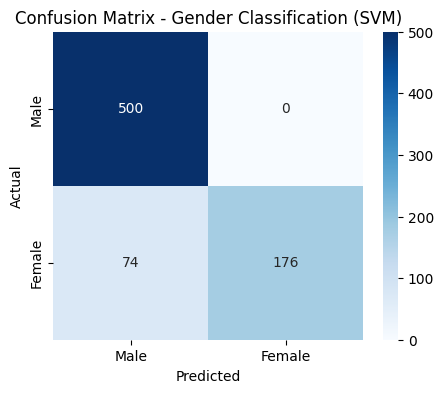

In [29]:
cm = confusion_matrix(y_test, y_pred_svm)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Male','Female'], yticklabels=['Male','Female'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Gender Classification (SVM)")

cm_plot_path = os.path.join(PLOTS_DIR, "SVM_confusion_matrix.png")
plt.savefig(cm_plot_path)
plt.show()
plt.close()

### 7.3 Save SVM Model

In [37]:
svm_path = os.path.join(MODELS_DIR, "svm_model.pkl")
joblib.dump(svm_model, svm_path)
print(f"SVM model saved at: {svm_path}")

SVM model saved at: saved_models/svm_model.pkl


## 8. Small Neural Network

### 8.1 Training and Evaluation

In [39]:
y_train_cat = to_categorical(y_train, num_classes=2)
y_test_cat = to_categorical(y_test, num_classes=2)

class_weights_values = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights_values))

nn_model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(2, activation='softmax')
])

nn_model.compile(optimizer=Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])

best_model_path = os.path.join(MODELS_DIR, "best_nn_model.h5")
checkpoint = ModelCheckpoint(
    filepath=best_model_path,
    monitor='val_accuracy',   
    save_best_only=True,
    verbose=1
)

history = nn_model.fit(
    X_train, y_train_cat,
    validation_data=(X_test, y_test_cat),
    epochs=50,
    batch_size=32,
    class_weight=class_weight_dict,
    verbose=1,
    callbacks=[checkpoint]
)

print(f"NN model saved at: {best_model_path}")

y_pred_nn_prob = nn_model.predict(X_test)
y_pred_nn = np.argmax(y_pred_nn_prob, axis=1)

acc = accuracy_score(y_test, y_pred_nn)
report = classification_report(y_test, y_pred_nn, target_names=['Male','Female'])
 
print("NN Accuracy:", acc) 
print("\nNN Classification Report:\n", report)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


44/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5072 - loss: 11.8445
Epoch 1: val_accuracy improved from -inf to 0.84267, saving model to saved_models/best_nn_model.h5


55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.5183 - loss: 11.0256 - val_accuracy: 0.8427 - val_loss: 0.5928
Epoch 2/50
45/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7437 - loss: 1.9106
Epoch 2: val_accuracy improved from 0.84267 to 0.91333, saving model to saved_models/best_nn_model.h5


55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7506 - loss: 1.8381 - val_accuracy: 0.9133 - val_loss: 0.3508
Epoch 3/50
44/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8535 - loss: 1.1029
Epoch 3: val_accuracy improved from 0.91333 to 0.95733, saving model to saved_models/best_nn_model.h5


55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8542 - loss: 1.0864 - val_accuracy: 0.9573 - val_loss: 0.1363
Epoch 4/50
46/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8733 - loss: 0.7541
Epoch 4: val_accuracy improved from 0.95733 to 0.96000, saving model to saved_models/best_nn_model.h5


55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8779 - loss: 0.7201 - val_accuracy: 0.9600 - val_loss: 0.1305
Epoch 5/50
44/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8956 - loss: 0.6144
Epoch 5: val_accuracy did not improve from 0.96000
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9003 - loss: 0.5833 - val_accuracy: 0.9280 - val_loss: 0.2697
Epoch 6/50
47/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9178 - loss: 0.4384
Epoch 6: val_accuracy did not improve from 0.96000
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9191 - loss: 0.4287 - val_accuracy: 0.9507 - val_loss: 0.1779
Epoch 7/50
44/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9256 - loss: 0.3378
Epoch 7: val_accuracy did not improve from 0.96000
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9270 - loss: 0.3368 - val_accuracy: 0.8653 - val_loss: 0.7278
Epoch 8/50
39/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9332 - loss: 0.4358
Epoch 8: val_accuracy did not improve from 0.96000


### 8.2 Plots

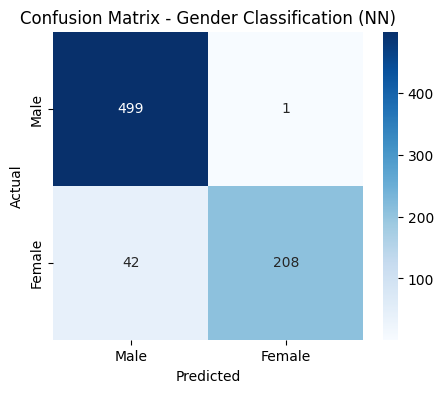

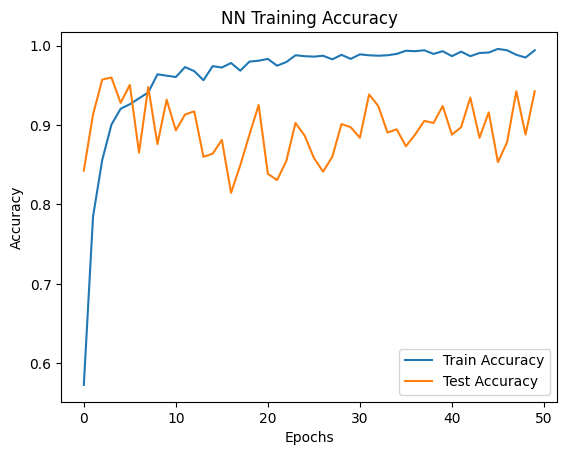

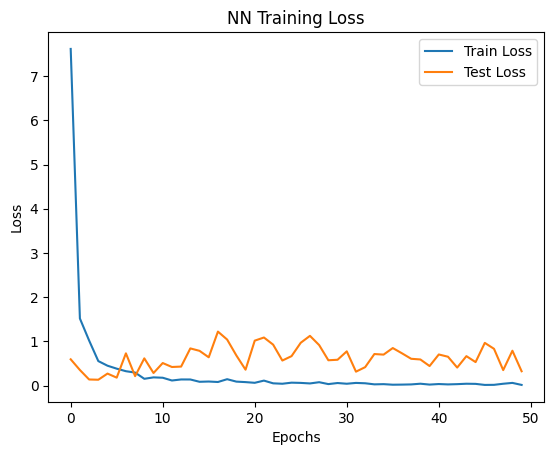

In [40]:
cm = confusion_matrix(y_test, y_pred_nn)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Male','Female'], yticklabels=['Male','Female'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Gender Classification (NN)")

cm_plot_path = os.path.join(PLOTS_DIR, "nn_confusion_matrix.png")
plt.savefig(cm_plot_path)
plt.show()
plt.close() 


plt.figure()
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('NN Training Accuracy')
plt.savefig(os.path.join(PLOTS_DIR, "nn_training_accuracy.png"))
plt.show()
plt.close()


plt.figure()
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('NN Training Loss')
plt.savefig(os.path.join(PLOTS_DIR, "nn_training_loss.png"))
plt.show()
plt.close()
 